## Best Result per Fold

In [21]:
from collections import Counter
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import RobustScaler

import random
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import plotly.express as px

plt.style.use('default')

df = pd.read_csv('output/result_10_fold.csv')[['fold', 'n_genes', 'auc_valid', 
                                               'tp', 'fp', 'tn', 'fn']]

df_best = df.groupby('fold').apply(lambda x: pd.Series({
    'n_genes': x.set_index('n_genes')['auc_valid'].idxmax()
})).reset_index()

df_best['n_genes'] = df_best['n_genes'].astype(int)

df_best.T

,0,1,2,3,4,5,6,7,8,9
fold,1,2,3,4,5,6,7,8,9,10
n_genes,36,39,36,24,21,22,34,25,37,25



## Mean Result

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

df1 = pd.read_csv('output/inference_valid_10_fold.csv')
del df1['Unnamed: 0']
df1 = df1.rename(columns={'n_feats': 'n_genes'})

df2 = pd.read_csv('output/result_10_fold.csv')[['fold', 'n_genes', 'y_train_hat_min', 'y_train_hat_max']]

df3 = pd.merge(df1, df2, on=['fold', 'n_genes'])
df3['y_hat_adjusted'] = df3.apply(lambda x: (x['y_hat'] - x['y_train_hat_min']) / (x['y_train_hat_max'] - x['y_train_hat_min']), axis=1)
df3['y_hat_hard'] = df3.apply(lambda x: int(x['y_hat'] >= x['threshold']), axis=1)
df3 = df3.fillna('non-therapy')

df3 = df3.merge(df, on=['fold', 'n_genes'], how='inner')

df3['therapy']  = df3['therapy'].apply(lambda x: x.replace('therapy_first_line_', ''))

df3 = df3.merge(df_best, on=['fold', 'n_genes'], how='inner')

def classification_metrics(x):
    tn, fp, fn, tp = confusion_matrix(x['y_true'], x['y_hat_hard']).ravel()
    return pd.Series({
        'AUC': roc_auc_score(x['y_true'], x['y_hat_adjusted']),
        'Accuracy': accuracy_score(x['y_true'], x['y_hat_hard']),
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp)
})

ddd = pd.DataFrame(df3.groupby(['fold']).apply(classification_metrics))

ddd.reset_index()

,fold,AUC,Accuracy,Sensitivity,Specificity
0,1,0.809091,0.726027,0.555556,0.781818
1,2,0.742246,0.777778,0.058824,1.000000
2,3,0.721925,0.236111,1.000000,0.000000
3,4,0.758289,0.736111,0.294118,0.872727
4,5,0.764706,0.718310,0.529412,0.777778
5,6,0.795207,0.788732,0.117647,1.000000
6,7,0.777778,0.774648,0.470588,0.870370
7,8,0.726580,0.661972,0.588235,0.685185
8,9,0.679194,0.746479,0.294118,0.888889
9,10,0.684096,0.760563,0.235294,0.925926


## Result per Therapy

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

df1 = pd.read_csv('output/inference_valid_10_fold.csv')
del df1['Unnamed: 0']
df1 = df1.rename(columns={'n_feats': 'n_genes'})

df2 = pd.read_csv('output/result_10_fold.csv')[['fold', 'n_genes', 'y_train_hat_min', 'y_train_hat_max']]

df3 = pd.merge(df1, df2, on=['fold', 'n_genes'])
df3['y_hat_adjusted'] = df3.apply(lambda x: (x['y_hat'] - x['y_train_hat_min']) / (x['y_train_hat_max'] - x['y_train_hat_min']), axis=1)
df3['y_hat_hard'] = df3.apply(lambda x: int(x['y_hat'] >= x['threshold']), axis=1)
df3 = df3.fillna('non-therapy')

df3 = df3.merge(df, on=['fold', 'n_genes'], how='inner')

df3['therapy']  = df3['therapy'].apply(lambda x: x.replace('therapy_first_line_', ''))

df3 = df3.merge(df_best, on=['fold', 'n_genes'], how='inner')

def classification_metrics(x):
    tn, fp, fn, tp = confusion_matrix(x['y_true'], x['y_hat_hard']).ravel()
    return pd.Series({
        'AUC': roc_auc_score(x['y_true'], x['y_hat_adjusted']),
        'Accuracy': accuracy_score(x['y_true'], x['y_hat_hard']),
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp)
})

ddd = pd.DataFrame(df3.groupby(['therapy']).apply(classification_metrics))

ddd.reset_index()

,therapy,AUC,Accuracy,Sensitivity,Specificity
0,bor-cyc-dex,0.642241,0.631579,0.275862,0.730769
1,bor-dex,0.627820,0.734375,0.285714,0.789474
2,bor-len-dex,0.803689,0.728814,0.553846,0.795322
3,len-dex,0.694352,0.640000,0.428571,0.674419
4,non-therapy,0.729924,0.689655,0.349206,0.816568


# Optimization Visualization

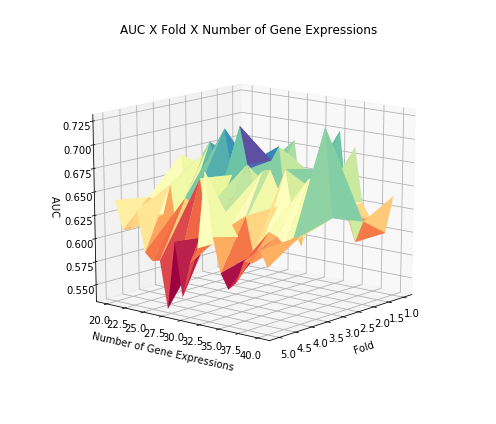

In [4]:
%matplotlib inline

df = pd.read_csv('output/result_5_fold.csv')

all_data = {'tax': [], 'duration': [], 'month_value': [], 'salary': [], 'return': [], 'total_loan': []}

fig = plt.figure(figsize=(7, 6), facecolor=(1, 1, 1))
    
a = df[['fold', 'auc_valid', 'n_genes']].copy()
b = df[['accuracy', 'sensitivity','specificity', 'precision', 'ks', 'n_feats']].copy()

ax = fig.add_subplot(1, 1, 1, projection='3d', facecolor=(1, 1, 1))    

ax.set_title('AUC X Fold X Number of Gene Expressions')

# X = np.sqrt(np.abs(a.pca2d1))
# Y = np.sqrt(np.abs(a.pca2d2))
X = a.fold.astype(int)
Y = a.n_genes.astype(int)
Z = a.auc_valid

# Z = np.ones_like(X)*a.auc_valid.values.tolist() + np.zeros_like(Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)

# ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

# norm = matplotlib.colors.Normalize(vmin=0, vmax=3)

ax.plot_trisurf(X, Y, Z, cmap=plt.cm.Spectral, shade=False)

# ax.scatter(a.n_genes, a.pca1d, a.auc_valid, c=a.auc_valid, linewidth=0.5)
# ax.scatter(a.pca2d1, a.pca2d2, a.auc_valid, c=a.auc_valid, linewidth=0.5)
# ax.scatter3D(X, Y, Z, c=Z, linewidth=0.5)

ax.view_init(15, 40)

ax.set_xlabel('\nFold')
ax.set_ylabel('\nNumber of Gene Expressions')
ax.set_zlabel('AUC   ')
ax.zaxis.labelpad=8
ax.dist = 12
fig.tight_layout()
plt.show()

In [5]:
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = [np.log(x[1]) for x in [(1583222400000, 107000), (1583226000000, 107000), (1583229600000, 110500), (1583233200000, 108000), (1583236800000, 104000), (1583240400000, 109000), (1583244000000, 107000), (1583247600000, 107000), (1583251200000, 107000), (1583254800000, 109500), (1583258400000, 107500), (1583262000000, 106500), (1583265600000, 108667), (1583269200000, 109000), (1583272800000, 108500), (1583276400000, 107000), (1583280000000, 105000), (1583283600000, 106667), (1583287200000, 103667), (1583290800000, 109500), (1583294400000, 106000), (1583298000000, 104000), (1583301600000, 107000), (1583305200000, 108000)]]
print(np.exp(data))
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data) + 10, typ='levels')
print(np.max(np.exp(yhat)))

[107000. 107000. 110500. 108000. 104000. 109000. 107000. 107000. 107000.
 109500. 107500. 106500. 108667. 109000. 108500. 107000. 105000. 106667.
 103667. 109500. 106000. 104000. 107000. 108000.]
106287.14414443613


In [6]:
len([(1583222400000, 107000), (1583226000000, 107000), (1583229600000, 110500), (1583233200000, 108000), (1583236800000, 104000), (1583240400000, 109000), (1583244000000, 107000), (1583247600000, 107000), (1583251200000, 107000), (1583254800000, 109500), (1583258400000, 107500), (1583262000000, 106500), (1583265600000, 108667), (1583269200000, 109000), (1583272800000, 108500), (1583276400000, 107000), (1583280000000, 105000), (1583283600000, 106667), (1583287200000, 103667), (1583290800000, 109500), (1583294400000, 106000), (1583298000000, 104000), (1583301600000, 107000), (1583305200000, 108000)])

24

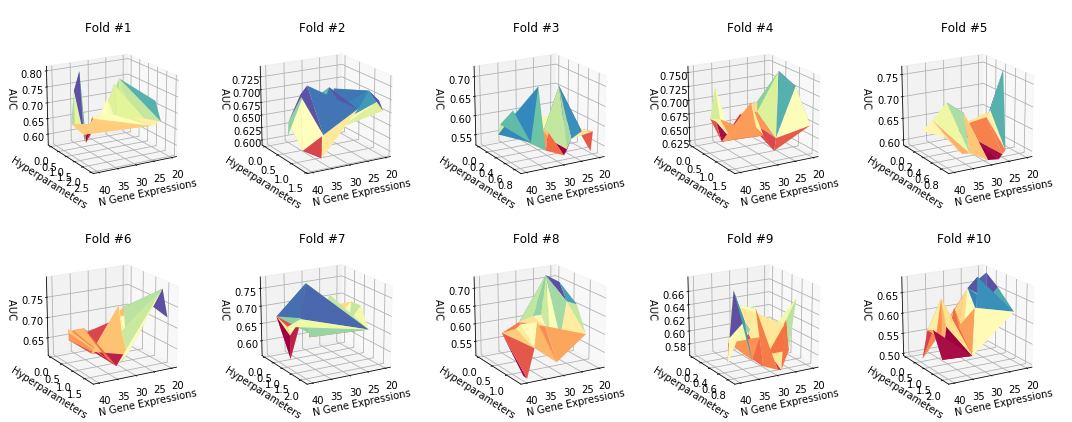

In [7]:
%matplotlib inline

from sklearn.preprocessing import RobustScaler


df = pd.read_csv('output/result_10_fold.csv')

all_data = {'tax': [], 'duration': [], 'month_value': [], 'salary': [], 'return': [], 'total_loan': []}

fig = plt.figure(figsize=(15, 6), facecolor=(1, 1, 1))

for fold in range(1, 11):
    
    a = df.loc[df['fold'] == fold][['auc_valid', 'n_genes']].copy()
    b = df.loc[df['fold'] == fold][['accuracy', 'sensitivity','specificity', 'precision', 'ks', 'n_feats']].copy()
    # pca1d = PCA(n_components=1).fit_transform(b.fillna(0))
    pca2d = RobustScaler().fit_transform(PCA(n_components=1).fit_transform(b.fillna(0)))
    # a['pca1d'] = pca1d[:,0]
    a['pca2d1'] = pca2d[:,0]
    #a['pca2d2'] = pca2d[:,1]
    
    ax = fig.add_subplot(2, 5, fold, projection='3d', facecolor=(1, 1, 1))    

    ax.set_title('\nFold #{}'.format(fold))
    
    # X = np.sqrt(np.abs(a.pca2d1))
    X = a.n_genes
    Y = np.sqrt(np.abs(a.pca2d1))
    # Y = np.sqrt(np.abs(a.pca2d2))
    # Y = a.n_genes
    Z = a.auc_valid
    
    # Z = np.ones_like(X)*a.auc_valid.values.tolist() + np.zeros_like(Y)
    # R = np.sqrt(X**2 + Y**2)
    # Z = np.sin(R)
    
    # ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    
    # norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
    
    ax.plot_trisurf(X, Y, Z, cmap=plt.cm.Spectral, shade=False)
    
    # ax.scatter(a.n_genes, a.pca1d, a.auc_valid, c=a.auc_valid, linewidth=0.5)
    # ax.scatter(a.pca2d1, a.pca2d2, a.auc_valid, c=a.auc_valid, linewidth=0.5)
    # ax.scatter3D(a.pca2d1, a.pca2d2, a.auc_valid, c=a.auc_valid, linewidth=0.5)
    
    ax.view_init(20, 60)

    ax.set_xlabel('N Gene Expressions')
    ax.set_ylabel('Hyperparameters')
    ax.set_zlabel('AUC   ')
    ax.zaxis.labelpad=8
    ax.dist = 12
    # plt.subplots_adjust(bottom=.8)
fig.tight_layout()
plt.show()

In [8]:
import ipywidgets as widgets

tab_contents = ['P0', 'P1', 'P2', 'P3', 'P4']
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = [str(i) for i in range(len(children))]

tab